In [17]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, make_scorer, confusion_matrix, plot_roc_curve, plot_confusion_matrix

from copy import copy

from time import time

import matplotlib.pyplot as plt
import category_encoders as ce

In [18]:
df = pd.read_csv('data/us census data.csv')
df = df.replace("?","Other")

In [19]:
df.head()

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Cuba,0,<=50K


In [20]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,48842.0,NaN,NaN,NaN,38.643585,13.71051,17.0,28.0,37.0,48.0,90.0
workclass,48842,7,Private,33906,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fnlwgt,48842.0,NaN,NaN,NaN,189664.134597,105604.025423,12285.0,117550.5,178144.5,237642.0,1490400.0
education,48842,16,HS-grad,15784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
marital-status,48842,7,Married-civ-spouse,22379,NaN,NaN,NaN,NaN,NaN,NaN,NaN
occupation,48842,15,Prof-specialty,6172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
relationship,48842,6,Husband,19716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
race,48842,5,White,41762,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,48842,2,Male,32650,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hours-per-week,48842.0,NaN,NaN,NaN,40.422382,12.391444,1.0,40.0,40.0,45.0,99.0


In [21]:
cat_df = copy(df)
cat_df.iloc[:,np.where(cat_df.dtypes == object)[0]] = cat_df.iloc[:,np.where(cat_df.dtypes == object)[0]].astype('category')

In [22]:
X = cat_df.iloc[:,:-1]
y = cat_df.iloc[:,-1]

ordinal_encoder = OrdinalEncoder(dtype=int)
label_encoder = LabelEncoder()

X_cat = X.iloc[:,np.where(X.dtypes == 'category')[0]]

X_enc_cat = ordinal_encoder.fit_transform(X_cat)
X_enc = copy(X)
X_enc.iloc[:,np.where(X.dtypes == 'category')[0]] = X_enc_cat
y_enc = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=1)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc,y_enc,test_size=0.2, random_state=1)

In [23]:
scoring = {'accuracy': make_scorer(accuracy_score)}

parameters = {
    "learning_rate": [0.05, 0.1, 0.2, 0.5],
    "max_depth":[3,4,5],
    "n_estimators": [100,200,300,400,500]
}

gbc_gs = GridSearchCV(GradientBoostingClassifier(), parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

gbc_gs.fit(X_train_enc, y_train_enc)
gbc_df = pd.DataFrame.from_dict(gbc_gs.cv_results_)

In [24]:
def get_best_params(cf_results_df):
    max_ind = cf_results_df['mean_test_accuracy'].argmax()
    thresh = cf_results_df['mean_test_accuracy'][max_ind] - cf_results_df['std_test_accuracy'][max_ind]
    min_ind = cf_results_df[cf_results_df['mean_test_accuracy'] >= thresh]['mean_fit_time'].argmin()
    return cf_results_df['params'][min_ind]

In [25]:
get_best_params(gbc_df)

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 300}

In [26]:
start = time()
gbc = GradientBoostingClassifier(learning_rate=0.2,max_depth=3,n_estimators=100)
gbc.fit(X_train_enc,y_train_enc)
end = time()
print("Fitting time: ",end-start)

Fitting time:  3.7940125465393066


In [27]:
def evaluate_model(model,X_test,y_test,verbose=True):
    y_pred = model.predict(X_test)
    label_encoder = LabelEncoder()
    y_test_f1, y_pred_f1 = label_encoder.fit_transform(y_test), label_encoder.fit_transform(y_pred)

    if verbose:
        plot_roc_curve(model,X_test,y_test)
        plot_confusion_matrix(model, X_test, y_test,normalize='true')

    return accuracy_score(y_test,y_pred), f1_score(y_test_f1,y_pred_f1)

(0.8692803767018119, 0.6994586961638033)

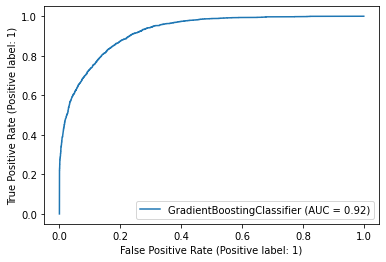

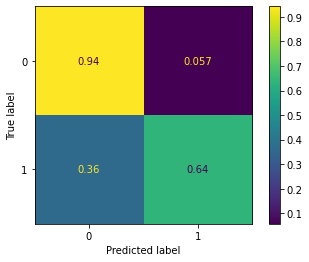

In [28]:
evaluate_model(gbc,X_test_enc,y_test_enc)

In [29]:
import catboost as cb

In [30]:
cat_features_indices = np.where(X_train.dtypes == 'category')[0]

In [31]:
cbc = cb.CatBoostClassifier(logging_level='Silent',eval_metric = 'Accuracy',cat_features=cat_features_indices)

scoring = {'accuracy': make_scorer(accuracy_score)}

parameters = {
    "max_depth":[2,3,4,5,6,7,8],
    "n_estimators": [100,200,300,400,500]
}
cbc_gs = GridSearchCV(cbc, parameters,scoring=scoring,refit=False,cv=5, n_jobs=-1)

cbc_gs.fit(X_train, y_train)
cbc_df=pd.DataFrame.from_dict(cbc_gs.cv_results_)

In [32]:
get_best_params(cbc_df)

{'max_depth': 2, 'n_estimators': 500}

In [33]:
train_dataset = cb.Pool(X_train,y_train,cat_features=cat_features_indices)
test_dataset = cb.Pool(X_test,y_test,cat_features=cat_features_indices)

start = time()
cbc = cb.CatBoostClassifier(logging_level='Silent',
                              cat_features=cat_features_indices,
                              depth=2,
                              iterations=500,
                              eval_metric='Accuracy'
                              )
cbc.fit(train_dataset,eval_set=test_dataset,plot=False)
end = time()
print("Fitting time: ",end-start)

Fitting time:  10.267954349517822


(0.8714300337803256, 0.7044705882352942)

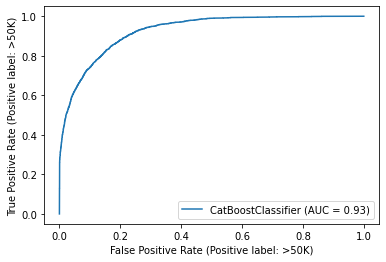

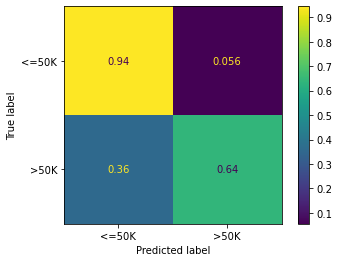

In [34]:
evaluate_model(cbc,X_test,y_test)

In [35]:
bin_df = copy(df)
bin_df.loc[bin_df['native-country'] != 'United-States', 'native-country'] = 'Other'

In [36]:
bin_df

,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,hours-per-week,native-country,capital,income
0,39,State-gov,77516,Bachelors,Never-married,Adm-clerical,Not-in-family,White,Male,40,United-States,2174,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,Married-civ-spouse,Exec-managerial,Husband,White,Male,13,United-States,0,<=50K
2,38,Private,215646,HS-grad,Divorced,Handlers-cleaners,Not-in-family,White,Male,40,United-States,0,<=50K
3,53,Private,234721,11th,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,40,United-States,0,<=50K
4,28,Private,338409,Bachelors,Married-civ-spouse,Prof-specialty,Wife,Black,Female,40,Other,0,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,39,Private,215419,Bachelors,Divorced,Prof-specialty,Not-in-family,White,Female,36,United-States,0,<=50K
48838,64,Other,321403,HS-grad,Widowed,Other,Other-relative,Black,Male,40,United-States,0,<=50K
48839,38,Private,374983,Bachelors,Married-civ-spouse,Prof-specialty,Husband,White,Male,50,United-States,0,<=50K
48840,44,Private,83891,Bachelors,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,40,United-States,5455,<=50K


<BarContainer object of 2 artists>

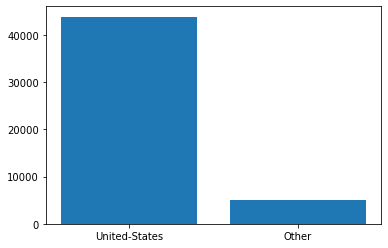

In [37]:
plt.bar(bin_df['native-country'].unique(),bin_df['native-country'].value_counts())

In [38]:
def encode_df(df, encode_method):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]

    y = LabelEncoder().fit_transform(y)

    encoder = encode_method(cols=X.iloc[:,np.where(X.dtypes == object)[0]].columns,return_df=True)
    X = encoder.fit_transform(X)

    return pd.concat((X,pd.Series(y).rename('income')),axis=1)

In [39]:
def compare_encoding(name_list,df_list,encode_list,iters=10):
    out = pd.DataFrame(columns=["name","mean_time","std-time","accuracy","f1_score"])
    for i, name in enumerate(name_list):
        times = []
        for j in range(iters):
            df = encode_df(df_list[i],encode_list[i])
            X_train, X_test, y_train, y_test = train_test_split(df.iloc[:,:-1],df.iloc[:,-1],test_size=0.2, random_state=1)
            start = time()
            gbc = GradientBoostingClassifier(learning_rate=0.2,max_depth=3,n_estimators=100)
            gbc.fit(X_train,y_train)
            end = time()
            times.append(end-start)

            acc, f1 = evaluate_model(gbc,X_test,y_test,verbose=False)

        mean_time = np.mean(times)
        std_time = np.std(times)
        out.loc[i] = [name,mean_time,std_time,acc,f1]

    return out

In [40]:
compare_encoding(["OneHot","Ordinal","BinaryOneHot","BinaryOrdinal"],
                 [df,df,bin_df,bin_df],
                 [ce.OneHotEncoder,ce.OrdinalEncoder,ce.OneHotEncoder,ce.OrdinalEncoder])

,name,mean_time,std-time,accuracy,f1_score
0,OneHot,7.962132,0.074630,0.870304,0.697107
1,Ordinal,3.671192,0.019179,0.869178,0.693231
2,BinaryOneHot,6.049944,0.026046,0.870509,0.697585
3,BinaryOrdinal,3.608442,0.030032,0.869383,0.694005


In [41]:
import pickle

pickle.dump(gbc, open("./models/gbc.dat", "wb"))
pickle.dump(cbc, open("./models/cbc.dat", "wb"))

In [42]:
gbc = pickle.load(open("./models/gbc.dat", "rb"))